In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.io import loadmat
import random
import IPython
import yaml

from homtools import get_eigenmike, reduced_eigenmike
from shtools import sound_pressure_from_hoa, get_real_sh
from utils import mystft, multichannel_fft_convolve, trim_signal_to_activity

draw = True  # Whether to plot or not
CONFIG_FILE_PATH = 'config.yaml'
try:
    with open(CONFIG_FILE_PATH, 'r') as file:
        # It's recommended to use yaml.safe_load() for security
        # as yaml.load() can execute arbitrary code.
        config = yaml.safe_load(file)
    print("YAML file loaded successfully!")
    # print(config) # Uncomment to see the full dictionary
except FileNotFoundError:
    print(f"Error: The file {CONFIG_FILE_FILE_PATH} was not found.")
    config = None
except yaml.YAMLError as exc:
    print(f"Error parsing YAML file: {exc}")
    config = None

# Set random seed for reproducibility
random.seed(42)

# User parameters from config file
c = config['general']['c']
fs = config['general']['fs']
winlen = config['general']['winlen']
sh_order = config['hoa_encoding']['sh_order']
Q = (sh_order + 1) ** 2
b_n_len = config['hoa_encoding']['b_n_len']

# Mic angles
hom = get_eigenmike(config['eigenmike']['mic_r'],
                    config['eigenmike']['mic_az'],
                    config['eigenmike']['mic_el'],
                    config['eigenmike']['gain'],
                    config['eigenmike']['w'],
                    isRigid=config['eigenmike']['micType']=='rigid')
# hom = reduced_eigenmike(Q, hom=hom_full)

# Directories
audio_output_dir = Path("/mnt/share/carabias/datasets/eigen32musdb18HQ/")
audio_dir = Path("/mnt/BBDD/Audio/musdb18HQ/train/")
rir_csv = "/mnt/share/carabias/datasets/simulated_rirs/info/rir_info_0_39.csv"
rir_dir = Path("/mnt/share/carabias/datasets/simulated_rirs/rir")
clean_rir_dir = Path("/mnt/share/carabias/datasets/simulated_rirs/rir_clean")

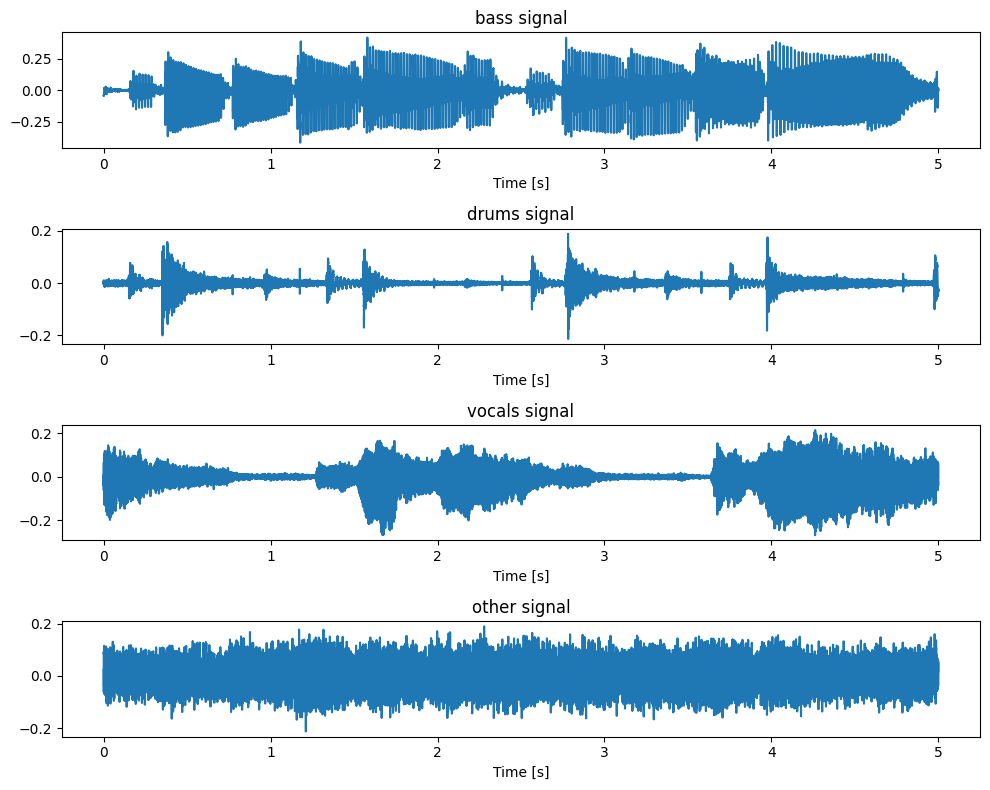

In [ ]:

# Read RIR info
rir_info = pd.read_csv(rir_csv)

# Get subfolders (each one is a song)
audio_dirs = sorted([f for f in audio_dir.iterdir() if f.is_dir()])
audio_info = []

# CAREFUL - Limit to first 1 for testing
audio_dirs = [audio_dirs[0]] 
for i, folder in enumerate(audio_dirs):
    song_id = f"train_{i+1}"

    # Load mono sources
    signals, valid_starts = [], []
    first_iter = True
    min_len = np.inf
    for name in ['bass', 'drums', 'vocals', 'other']:
        x, _ = sf.read(folder / f"{name}.wav")
        if x.ndim > 1:
            x = x[:, 0]
        signals.append(x)
        min_len = min(min_len, len(x))
        # Find valid start indices
        if first_iter:
            first_iter = False
            valid_start_idx = trim_signal_to_activity(x, fs)
        else:
            valid_start_idx  = np.intersect1d(valid_start_idx, trim_signal_to_activity(x, fs)) 

    # Trim to shortest length
    start_idx = np.random.choice(valid_start_idx)
    end_idx = min(start_idx + int(5 * fs), min_len)
    segment = [x[start_idx:end_idx] for x in signals] 
    
    # Draw signals and selected intervals
    if draw:
        fig, axs = plt.subplots(4, 1, figsize=(10, 8))
        time = np.arange(len(segment[0])) / fs
        for ax, sig, name in zip(axs, segment, ['bass', 'drums', 'vocals', 'other']):
            ax.plot(time, sig)
            ax.set_title(f"{name} signal")
            ax.set_xlabel("Time [s]")
        plt.tight_layout()
        plt.show()

In [ ]:
# Random room and RIRs
available_rooms = rir_info['room_id'].unique()
# CAREFUL 
target_room_id = 1 # random.choice(available_rooms)
available_rirs = rir_info[rir_info['room_id'] == target_room_id]['rir_id'].values
# CAREFUL 
target_rir_id = [1,2,3,4] # random.sample(list(available_rirs), 4)

# Convolve
audio_rev = []
audio_clean = []
mix_rev = None
mix_clean = None

for sidx, signal in enumerate(segment):
   rir_name = f"room{target_room_id}_{target_rir_id[sidx]}"
   print(rir_name)
   audio_info.append([song_id, str(folder / f"{sidx+1}"), f"{target_room_id}_{target_rir_id[sidx]}"])
   print([song_id, str(folder / f"{sidx+1}"), f"{target_room_id}_{target_rir_id[sidx]}"])

   # Load RIRs
   rir = loadmat(rir_dir / f"{rir_name}.mat")['sim_rir'].astype(np.float64)
   rir_clean = loadmat(clean_rir_dir / f"{rir_name}_clean.mat")['sim_rir_clean'].astype(np.float64)

   if hom.emReference is not None:
      rir = rir[hom.emReference, :]
      rir_clean = rir_clean[hom.emReference, :]
    
   # Do the first convolution just to get the length
   tmp_rev = multichannel_fft_convolve(rir, signal)
   tmp_clean = multichannel_fft_convolve(rir_clean, signal)

   # GT signals
   audio_rev.append(tmp_rev)
   audio_clean.append(tmp_clean)

   # Initialize accumulation arrays on first iteration
   if mix_rev is None:
      mix_rev = np.zeros_like(tmp_rev)
      mix_clean = np.zeros_like(tmp_clean)

   # Accumulate into mixture
   mix_rev += tmp_rev
   mix_clean += tmp_clean

room1_1
['train_1', '/mnt/BBDD/Audio/musdb18HQ/train/A Classic Education - NightOwl/1', '1_1']
room1_2
['train_1', '/mnt/BBDD/Audio/musdb18HQ/train/A Classic Education - NightOwl/2', '1_2']
room1_3
['train_1', '/mnt/BBDD/Audio/musdb18HQ/train/A Classic Education - NightOwl/3', '1_3']
room1_4
['train_1', '/mnt/BBDD/Audio/musdb18HQ/train/A Classic Education - NightOwl/4', '1_4']


In [11]:
# GETTING THE MIXTURE HOA ENCODING
# 1. STFT
nmic = rir.shape[0]
nsample_stft = get_nframes(len(mix_rev[0]))
freqs_stft = get_stft_freqs(fs=fs)

sp = np.zeros((nmic, WINLEN+1, nsample_stft), dtype=complex)
sp_clean = np.zeros_like(sp)

for m in range(nmic):
    sp[m, :, :] = mystft(mix_rev[m], fs=fs)
    sp_clean[m, :, :] = mystft(mix_clean[m], fs=fs)
    
# 2. Compute Real valued Alpha
alpha, _ = real_alpha_omni_mic_array(sp, sh_order, freqs_stft, mic_el, mic_az, rmic)
alpha_clean, _ = real_alpha_omni_mic_array(sp, sh_order, freqs_stft, mic_el, mic_az, rmic)

# 3. Get the HOA encoding
hoa, hoa_clean = [], []
for shc in range(alpha.shape[0]):
    hoa.append(myistft(np.squeeze(alpha[shc, :, :]), fs=fs))
    hoa_clean.append(myistft(np.squeeze(alpha_clean[shc, :, :]), fs=fs))
hoa = np.array(hoa)
hoa_clean = np.array(hoa_clean)

/mnt/share/carabias/hoa-simulations/shtools.py:64: RuntimeWarning: invalid value encountered in multiply
  return spherical_jn(n, x) + 1j * spherical_yn(n, x)


In [13]:
# GETTING THE ISOLATED SIGNALS HOA ENCODING
# 1. STFT
nmic = rir.shape[0]
nsample_stft = get_nframes(len(mix_rev[0]))
freqs_stft = get_stft_freqs(fs=fs)

gt_hoa, gt_hoa_clean = [], []

for sidx in range(len(audio_rev)):
    sp = np.zeros((nmic, WINLEN+1, nsample_stft), dtype=complex)
    sp_clean = np.zeros_like(sp)
    for m in range(nmic):
        sp[m, :, :] = mystft(audio_rev[sidx][m], fs=fs)
        sp_clean[m, :, :] = mystft(audio_clean[sidx][m], fs=fs)

    # 2. Compute Real valued Alpha
    alpha, _ = real_alpha_omni_mic_array(sp, sh_order, freqs_stft, mic_el, mic_az, rmic)
    alpha_clean, _ = real_alpha_omni_mic_array(sp, sh_order, freqs_stft, mic_el, mic_az, rmic)

    tmp_hoa, tmp_hoa_clean = [], []
    # 3. Get the HOA encoding
    for shc in range(alpha.shape[0]):
        tmp_hoa.append(myistft(np.squeeze(alpha[shc, :, :]), fs=fs))
        tmp_hoa_clean.append(myistft(np.squeeze(alpha_clean[shc, :, :]), fs=fs))
    tmp_hoa = np.array(hoa)
    tmp_hoa_clean = np.array(tmp_hoa_clean)
    
    # For each source, append its HOA encoding
    gt_hoa.append(tmp_hoa)
    gt_hoa_clean.append(tmp_hoa_clean)

/mnt/share/carabias/hoa-simulations/shtools.py:64: RuntimeWarning: invalid value encountered in multiply
  return spherical_jn(n, x) + 1j * spherical_yn(n, x)
